In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
n_top_similar = 100
n_top_anti_similar = 100
overwrite = False

Read knowledge graph information

In [3]:
if overwrite:
    knowledge_graph_orf = pd.read_csv(
        "~/Downloads/orf_scores_merged.zip",
        sep="\t",
        usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
    ).rename(
        columns={
            "GENE1": "gene_1",
            "GENE2": "gene_2",
            "gene_mf__go": "gene_mf",
            "gene_bp__go": "gene_bp",
        }
    )

    knowledge_graph_orf = pd.concat(
        [
            knowledge_graph_orf,
            knowledge_graph_orf.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
        ],
        ignore_index=True,
    )

    knowledge_graph_crispr = pd.read_csv(
        "~/Downloads/crispr_scores_merged.zip",
        sep="\t",
        usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
    ).rename(
        columns={
            "GENE1": "gene_1",
            "GENE2": "gene_2",
            "gene_mf__go": "gene_mf",
            "gene_bp__go": "gene_bp",
        }
    )

    knowledge_graph_crispr = pd.concat(
        [
            knowledge_graph_crispr,
            knowledge_graph_crispr.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
        ],
        ignore_index=True,
    )

    knowledge_graph = pd.concat(
        [knowledge_graph_orf, knowledge_graph_crispr], ignore_index=True
    ).drop_duplicates(subset=["gene_1", "gene_2"])

    knowledge_graph = knowledge_graph.assign(
        gene_kg=lambda x: np.max(x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1)
    ).drop(columns=["gene_mf", "gene_bp", "gene_pathway"])

In [4]:
# Read or create the top similar ORF genes

if os.path.isfile(f"output/orf_top_similar_genes_unknown.csv") and not overwrite:
    top_similar_genes_df = pd.read_csv(
        "output/orf_top_similar_genes_unknown.csv", index_col=0
    )
else:
    similarity_df = pd.read_parquet("cos_sim/cosine_similarities_genes_orf.parquet")

    similarity_df_stacked = (
        similarity_df.where(np.triu(np.ones(similarity_df.shape), k=1).astype(bool))
        .stack()
        .reset_index()
        .rename(columns={0: "cos_sim", "level_0": "gene_1", "level_1": "gene_2"})
    )

    similarity_df_stacked = similarity_df_stacked.query("gene_1 != gene_2")

    similarity_df_stacked = similarity_df_stacked.merge(
        knowledge_graph, on=["gene_1", "gene_2"], how="inner"
    ).query("gene_kg < 0.4")

    top_similar_genes_df_stacked = similarity_df_stacked.nlargest(
        n_top_similar, "cos_sim"
    )
    top_similar_genes = list(
        np.unique(
            [top_similar_genes_df_stacked.gene_1, top_similar_genes_df_stacked.gene_2]
        )
    )

    top_similar_genes_df = similarity_df.loc[top_similar_genes, top_similar_genes]

    top_similar_genes_df.to_csv("output/orf_top_similar_genes_unknown.csv")

In [5]:
# Read or create the top anti similar ORF genes

if os.path.isfile(f"output/orf_top_anti_similar_genes_unknown.csv") and not overwrite:
    top_anti_similar_genes_df = pd.read_csv(
        "output/orf_top_anti_similar_genes_unknown.csv", index_col=0
    )
else:
    similarity_df = pd.read_parquet("cos_sim/cosine_similarities_genes_orf.parquet")

    similarity_df_stacked = (
        similarity_df.where(np.triu(np.ones(similarity_df.shape), k=1).astype(bool))
        .stack()
        .reset_index()
        .rename(columns={0: "cos_sim", "level_0": "gene_1", "level_1": "gene_2"})
    )

    similarity_df_stacked = similarity_df_stacked.query("gene_1 != gene_2")

    similarity_df_stacked = similarity_df_stacked.merge(
        knowledge_graph, on=["gene_1", "gene_2"], how="inner"
    ).query("gene_kg < 0.4")

    top_anti_similar_genes_df_stacked = similarity_df_stacked.nsmallest(
        n_top_anti_similar, "cos_sim"
    )
    top_anti_similar_genes = list(
        np.unique(
            [
                top_anti_similar_genes_df_stacked.gene_1,
                top_anti_similar_genes_df_stacked.gene_2,
            ]
        )
    )

    top_anti_similar_genes_df = similarity_df.loc[
        top_anti_similar_genes, top_anti_similar_genes
    ]

    top_anti_similar_genes_df.to_csv("output/orf_top_anti_similar_genes_unknown.csv")

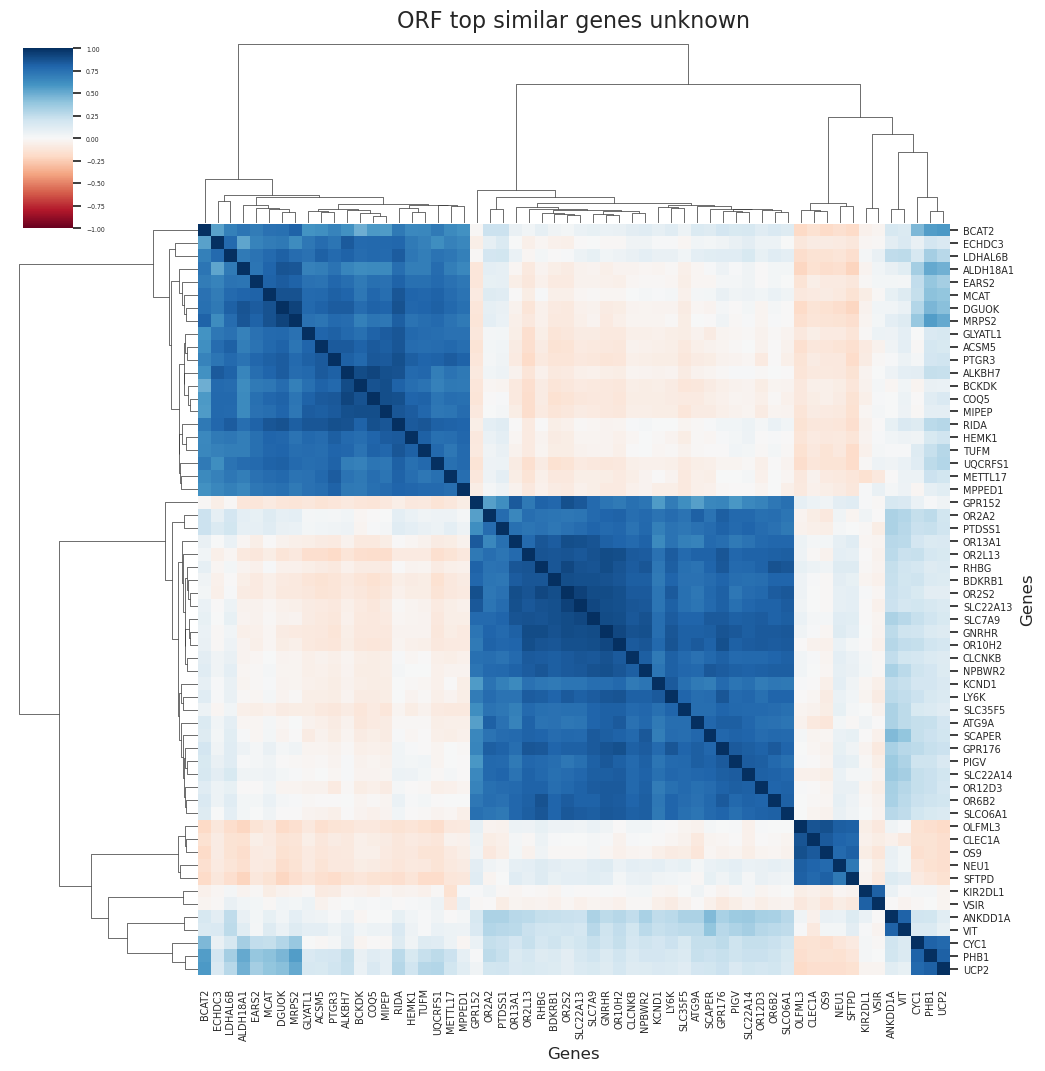

In [6]:
# Plot heatmap top similar genes

sns.set(rc={"figure.figsize": (48, 32)})
sns.set(font_scale=0.4)

f = sns.clustermap(
    top_similar_genes_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
)

f.ax_heatmap.set(xlabel="Genes", ylabel="Genes")
f.ax_heatmap.xaxis.label.set_size(12)
f.ax_heatmap.yaxis.label.set_size(12)
f.ax_heatmap.xaxis.set_tick_params(labelsize=7)
f.ax_heatmap.yaxis.set_tick_params(labelsize=7)
f.ax_heatmap.set_title("ORF top similar genes unknown", fontsize=16, y=1.25)
f.savefig("figures/orf_top_similar_genes_unknown.png", dpi=300)
f.savefig("figures/orf_top_similar_genes_unknown.svg", dpi=300)

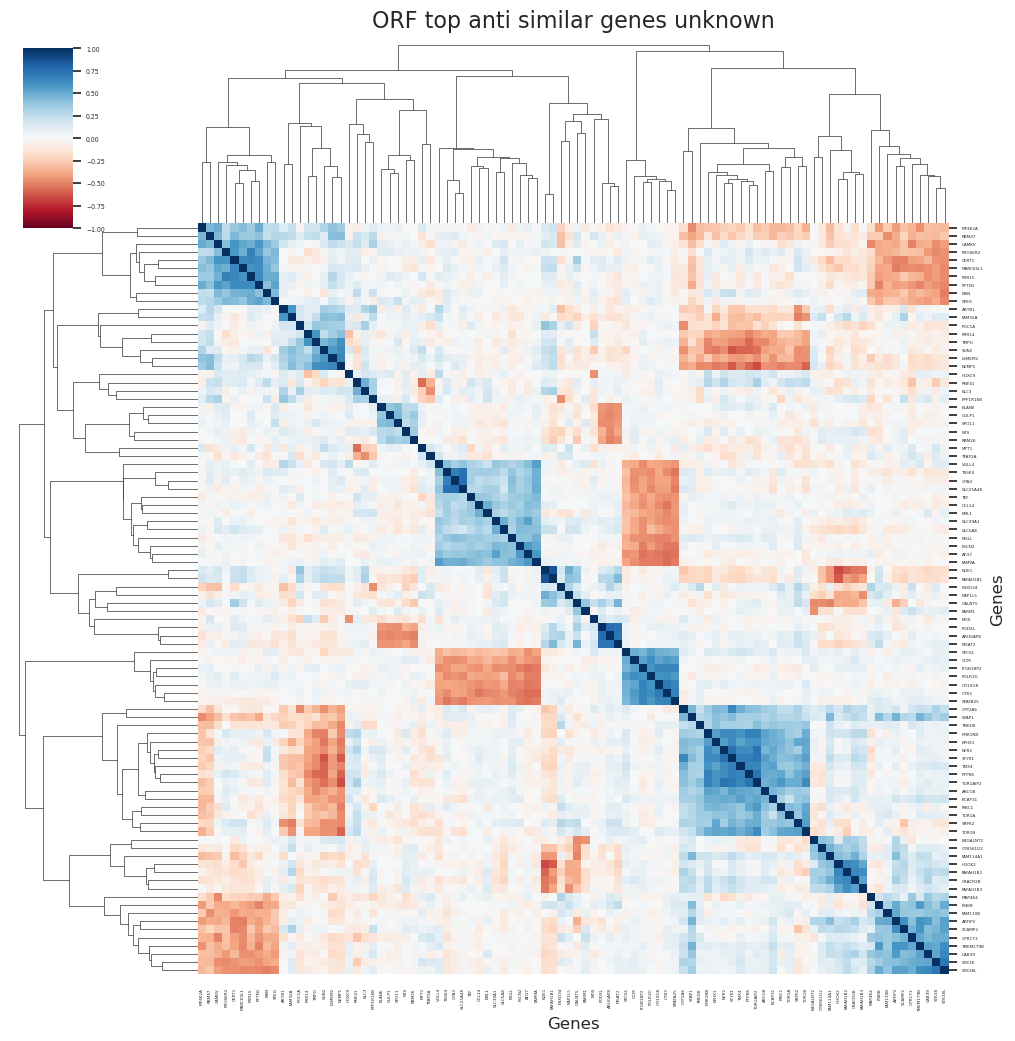

In [7]:
# Plot heatmap top anti similar genes

f = sns.clustermap(
    top_anti_similar_genes_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
)

f.ax_heatmap.set(xlabel="Genes", ylabel="Genes")
f.ax_heatmap.xaxis.label.set_size(12)
f.ax_heatmap.yaxis.label.set_size(12)
f.ax_heatmap.xaxis.set_tick_params(labelsize=3)
f.ax_heatmap.yaxis.set_tick_params(labelsize=3)
f.ax_heatmap.set_title("ORF top anti similar genes unknown", fontsize=16, y=1.25)
f.savefig("figures/orf_top_anti_similar_genes_unknown.png", dpi=300)
f.savefig("figures/orf_top_anti_similar_genes_unknown.svg", dpi=300)

In [8]:
# Read or create the top similar CRISPR genes

if os.path.isfile(f"output/crispr_top_similar_genes_unknown.csv") and not overwrite:
    top_similar_genes_df = pd.read_csv(
        "output/crispr_top_similar_genes_unknown.csv", index_col=0
    )
else:
    similarity_df = pd.read_parquet("cos_sim/cosine_similarities_genes_crispr.parquet")

    similarity_df_stacked = (
        similarity_df.where(np.triu(np.ones(similarity_df.shape), k=1).astype(bool))
        .stack()
        .reset_index()
        .rename(columns={0: "cos_sim", "level_0": "gene_1", "level_1": "gene_2"})
    )

    similarity_df_stacked = similarity_df_stacked.query("gene_1 != gene_2")

    similarity_df_stacked = similarity_df_stacked.merge(
        knowledge_graph, on=["gene_1", "gene_2"], how="inner"
    ).query("gene_kg < 0.4")

    top_similar_genes_df_stacked = similarity_df_stacked.nlargest(
        n_top_similar, "cos_sim"
    )
    top_similar_genes = list(
        np.unique(
            [top_similar_genes_df_stacked.gene_1, top_similar_genes_df_stacked.gene_2]
        )
    )

    top_similar_genes_df = similarity_df.loc[top_similar_genes, top_similar_genes]

    top_similar_genes_df.to_csv("output/crispr_top_similar_genes_unknown.csv")

In [9]:
# Read or create the top anti similar CRISPRgenes

if os.path.isfile(f"output/crispr_top_anti_similar_genes_unknown.csv") and not overwrite:
    top_anti_similar_genes_df = pd.read_csv(
        "output/crispr_top_anti_similar_genes_unknown.csv", index_col=0
    )
else:
    similarity_df = pd.read_parquet("cos_sim/cosine_similarities_genes_crispr.parquet")

    similarity_df_stacked = (
        similarity_df.where(np.triu(np.ones(similarity_df.shape), k=1).astype(bool))
        .stack()
        .reset_index()
        .rename(columns={0: "cos_sim", "level_0": "gene_1", "level_1": "gene_2"})
    )

    similarity_df_stacked = similarity_df_stacked.query("gene_1 != gene_2")

    similarity_df_stacked = similarity_df_stacked.merge(
        knowledge_graph, on=["gene_1", "gene_2"], how="inner"
    ).query("gene_kg < 0.4")

    top_anti_similar_genes_df_stacked = similarity_df_stacked.nsmallest(
        n_top_anti_similar, "cos_sim"
    )
    top_anti_similar_genes = list(
        np.unique(
            [
                top_anti_similar_genes_df_stacked.gene_1,
                top_anti_similar_genes_df_stacked.gene_2,
            ]
        )
    )

    top_anti_similar_genes_df = similarity_df.loc[
        top_anti_similar_genes, top_anti_similar_genes
    ]

    top_anti_similar_genes_df.to_csv("output/crispr_top_anti_similar_genes_unknown.csv")

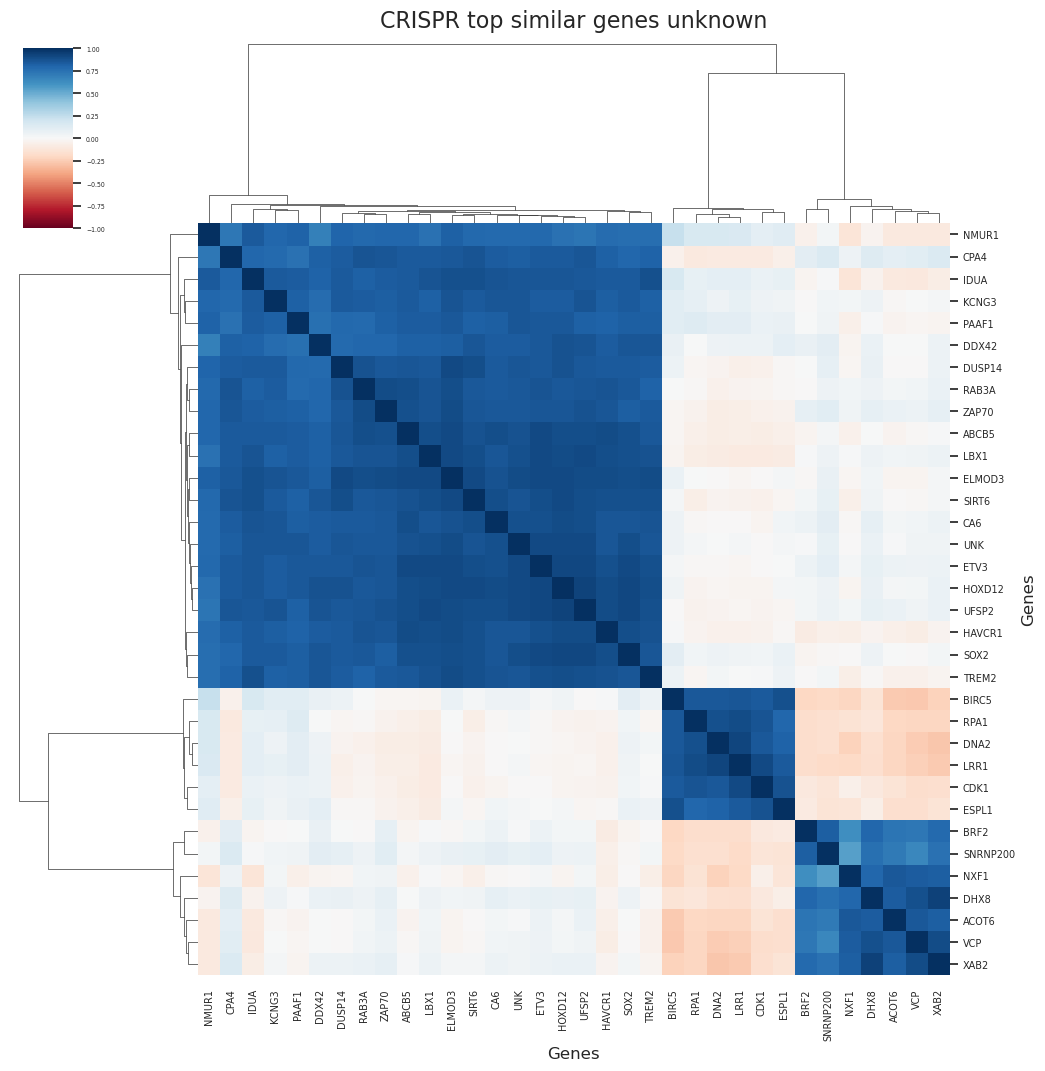

In [10]:
# Plot heatmap top similar genes

sns.set(rc={"figure.figsize": (48, 32)})
sns.set(font_scale=0.4)

f = sns.clustermap(
    top_similar_genes_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
)

f.ax_heatmap.set(xlabel="Genes", ylabel="Genes")
f.ax_heatmap.xaxis.label.set_size(12)
f.ax_heatmap.yaxis.label.set_size(12)
f.ax_heatmap.xaxis.set_tick_params(labelsize=7)
f.ax_heatmap.yaxis.set_tick_params(labelsize=7)
f.ax_heatmap.set_title("CRISPR top similar genes unknown", fontsize=16, y=1.25)
f.savefig("figures/crispr_top_similar_genes_unknown.png", dpi=300)
f.savefig("figures/crispr_top_similar_genes_unknown.svg", dpi=300)

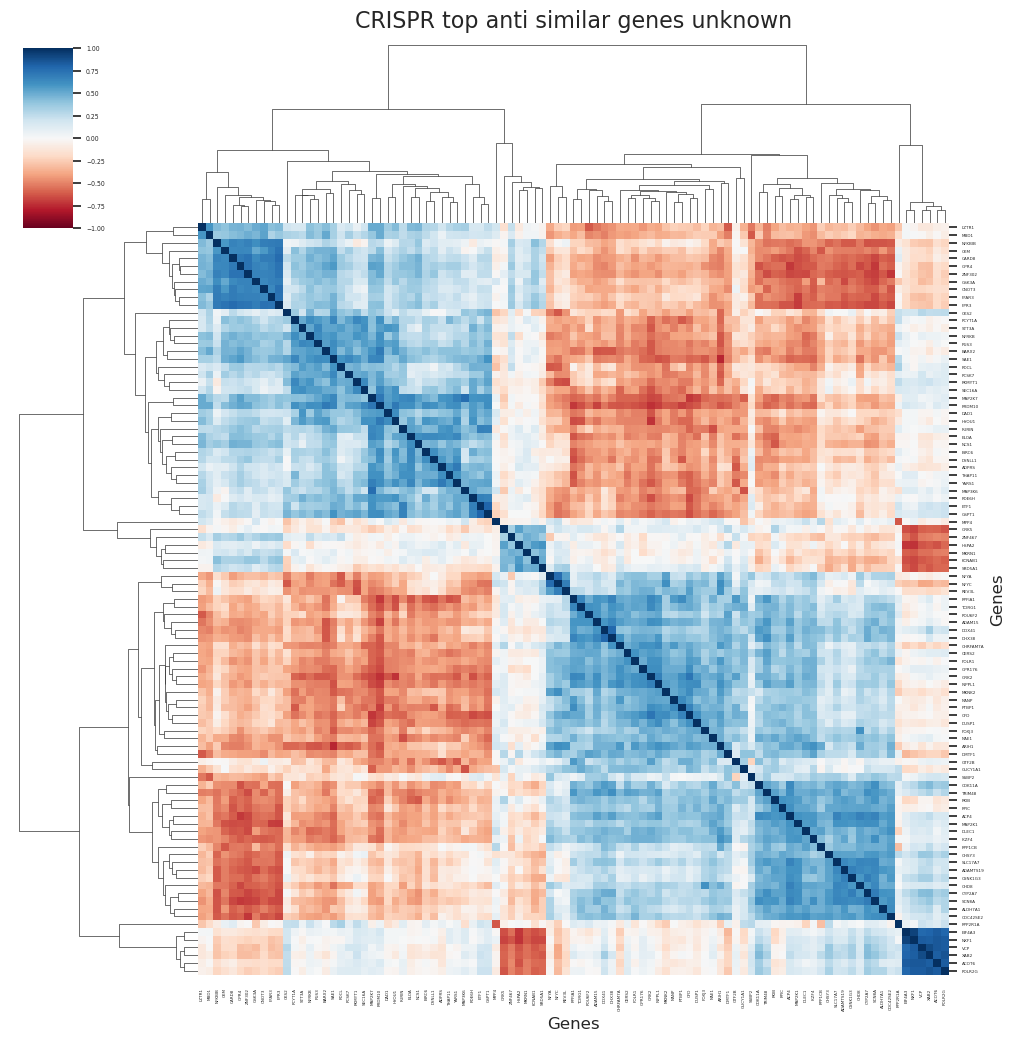

In [11]:
# Plot heatmap top anti similar genes

f = sns.clustermap(
    top_anti_similar_genes_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
)

f.ax_heatmap.set(xlabel="Genes", ylabel="Genes")
f.ax_heatmap.xaxis.label.set_size(12)
f.ax_heatmap.yaxis.label.set_size(12)
f.ax_heatmap.xaxis.set_tick_params(labelsize=3)
f.ax_heatmap.yaxis.set_tick_params(labelsize=3)
f.ax_heatmap.set_title("CRISPR top anti similar genes unknown", fontsize=16, y=1.25)
f.savefig("figures/crispr_top_anti_similar_genes_unknown.png", dpi=300)
f.savefig("figures/crispr_top_anti_similar_genes_unknown.svg", dpi=300)